## 3.1 Variational autoencoder

[Auto-Encoding Variational Bayes (Kingma, Welling, 2013)](https://arxiv.org/abs/1312.6114)

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Import the MNIST dataset in the same way as for the perceptron.

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


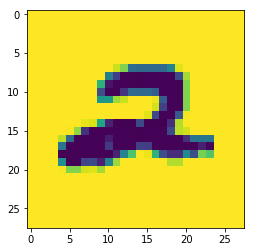

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

plt.imshow(np.reshape(-mnist.train.images[4242], (28, 28)), interpolation='none');

## Encoder

Create a placeholder called `x` for data minibatches of size 64. Then create two fully connected layers in the same way as for the classifier, but here with softplus nonlinearities instead of sigmoids (`tf.nn.softplus`). The last layer should map with a linear trainsformation into the parameters of the gaussian posterior. These should for now be two n_z dimensional vector variables named `z_mean` and `z_log_sigma_sq`.

In [ ]:
n_z = 2 #Dimension of the latent space
batch_size = 64

Now define the sampling from the variational posterior, where we need to generate z samples for the whole minibatch.

In [5]:
eps = tf.random_normal((batch_size, n_z), 0, 1, dtype=tf.float32) # Adding a random number
z = tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp(z_log_sigma_sq)), eps))  # The sampled z

## Decoder

The generative model or decoder takes the latent $z$ values as inputs and generates datapoints from them. Define a two-layer fully connected network again to use as a generative model of digits. The last layer should map linearly into a vector of mean pixel values named `x_reconstr_mean`.

## Loss function

The ELBO loss consists of the reconstruction and regularization terms. The first is the expected value of the log pdf of data conditioned on the inferred z value, the second is the kl divergence between the inferred posterior and the prior. The KL term can be calculated analytically for the case where both the prior and the posterior are gaussians.

## Training

In [ ]:
runs = 10 #Set to 0, for no training
n_samples = mnist.train.num_examples
init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    batch_xs, _ = mnist.train.next_batch(batch_size)
    print(batch_xs.shape)
    dd = sess.run([cost], feed_dict={x: batch_xs})
    print('Test run after starting {}'.format(dd))

    for epoch in range(runs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)
            _,d = sess.run((optimizer, cost), feed_dict={x: batch_xs})
            avg_cost += d / n_samples * batch_size

        # Display logs per epoch step
        if epoch % 1 == 0:
            save_path = saver.save(sess, "./model.ckpt") #Saves the weights (not the graph)
            print("Model saved in file: {}".format(save_path))
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

## Load and analyse model

In [13]:
check_point_file = "./model.ckpt"

In [ ]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, check_point_file)
    print("Model restored.")
    x_sample = mnist.test.next_batch(64)[0]
    x_reconstruct,z_vals,z_mean_val,z_log_sigma_sq_val  = sess.run((x_reconstr_mean,z, z_mean, z_log_sigma_sq), feed_dict={x: x_sample})

    plt.figure(figsize=(8, 12))
    for i in range(5):
        plt.subplot(5, 3, 3*i + 1)
        plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1,  interpolation='none',cmap=plt.get_cmap('gray'))
        plt.title("Test input")
        
        #plt.colorbar()
        plt.subplot(5, 3, 3*i + 2)
        plt.scatter(z_vals[:,0],z_vals[:,1], c='gray', alpha=0.5)
        plt.scatter(z_mean_val[i,0],z_mean_val[i,1], c='green', s=64, alpha=0.5)
        plt.scatter(z_vals[i,0],z_vals[i,1], c='blue', s=16, alpha=0.5)
       
        plt.xlim((-3,3))
        plt.ylim((-3,3))
        plt.title("Latent Space")
        
        plt.subplot(5, 3, 3*i + 3)
        plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, interpolation='none',cmap=plt.get_cmap('gray'))
        plt.title("Reconstruction")
        #plt.colorbar()
    plt.tight_layout()
    
    

In [ ]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, check_point_file)
    print("Model restored.")
    d = np.zeros([batch_size,2],dtype='float32')
    d[0,] = [1,2]
    x_reconstruct = sess.run(x_reconstr_mean, feed_dict={z: d})
    plt.imshow(x_reconstruct[0].reshape(28, 28), vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))

In [ ]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)
canvas = np.empty((28*ny, 28*nx))
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, check_point_file)
    for i, yi in enumerate(x_values):
        for j, xi in enumerate(y_values):
            z_mu = np.array([[xi, yi]])
            d[0] = z_mu
            x_mean = sess.run(x_reconstr_mean, feed_dict={z: d})
            canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))
plt.tight_layout()

In [17]:
saver = tf.train.Saver()
all_z = np.zeros((1,2))
all_z_vals = np.zeros((1,2))
with tf.Session() as sess:
    saver.restore(sess, check_point_file)
    total_batch = int(n_samples / batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        x_reconstruct,z_vals,z_mean_val,z_log_sigma_sq_val  = sess.run(
            (x_reconstr_mean,z, z_mean, z_log_sigma_sq), feed_dict={x: batch_xs})
        all_z = np.vstack((all_z, z_mean_val))
        all_z_vals = np.vstack((all_z_vals, z_vals))

INFO:tensorflow:Restoring parameters from ./model.ckpt


In [ ]:
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.scatter(all_z[:,0], all_z[:,1], s=0.2)
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.subplot(1,2,2)
plt.hist2d(all_z[:,0], all_z[:,1], (50, 50), cmap=plt.cm.jet)
plt.colorbar()

In [0]:
plt.close()
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.scatter(all_z[:,0], all_z[:,1], s=0.2)
plt.subplot(1,2,2)
plt.scatter(all_z_vals[:,0], all_z_vals[:,1], s=0.2)
plt.xlim(-3,3)
plt.ylim(-3,3)